# Explore `meta-kaggle` Dataset

## --- Test Synthetically Generated Data

We test the potential of our estimation algorithm by synthetically generated data.

In [1]:
# std library
from pprint import pprint
from datetime import datetime, timedelta

# third-party
from matplotlib import pyplot as plt
import numpy as np

# local
import ryvkin_model
import nhpp

### 1. Model Setting

In [2]:
# Capacities & Total Innovation Uncertainty
## Hour based
param_c_i = 1.5
param_c_j = 1.5
param_sigma = 1.0

# Contest related
param_theta = 2.0

# Signal Precision
param_lambda = 0.1

# Contest Time Duaration
time_step = 1 / 12
start_time = datetime(2025, 1, 1, 0, 0, 0)
end_time = datetime(2025, 4, 1, 0, 0, 0)
contest_days = (end_time - start_time).days
contest_seconds = int((end_time - start_time).total_seconds())
contest_hours = int(contest_seconds / 3600)
contest_timeticks = np.arange(start_time, end_time, \
		timedelta(hours=1), dtype=np.datetime64)

print(contest_days, contest_hours, len(contest_timeticks))

90 2160 2160


### 2. Simulations

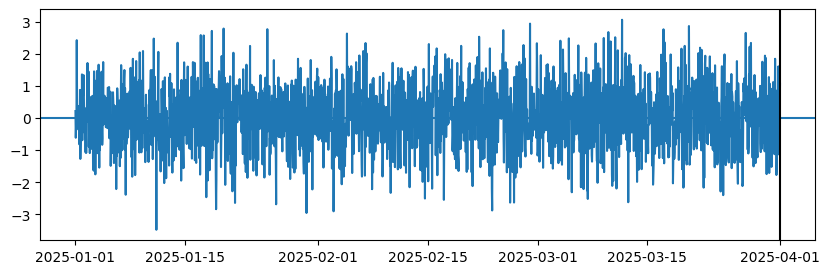

In [3]:
## Simulate a Path of Innovation Shocks
##
rng = np.random.default_rng(seed=337)
innovation_shocks = rng.normal(size=contest_hours)

plt.figure(figsize=(10, 3))
plt.plot(contest_timeticks, innovation_shocks)
yrange = plt.ylim()
xrange = plt.xlim()
plt.hlines(y = 0, xmin=xrange[0], xmax=xrange[1])
plt.vlines(x = end_time, ymin=yrange[0], ymax=yrange[1], colors='black')  # type: ignore
plt.xlim(xrange)
plt.ylim(yrange)
plt.show()

In [4]:
## Calculate the Dynamics of Efforts and Gap
##
dynamic_i_effort = np.zeros_like(contest_timeticks, dtype=np.float64)
dynamic_j_effort = np.zeros_like(contest_timeticks, dtype=np.float64)
dynamics_gap = np.zeros(shape = len(contest_timeticks), dtype=np.float64)

gap_t = 0
for idx_time, time in enumerate(contest_timeticks):
	q_i, q_j = ryvkin_model.get_equilibrium_efforts(gap_t, time, end_time,
			prize=param_theta,
			c_i=param_c_i,
			c_j=param_c_j,
			innov_uncert=param_sigma
	)
	shock = innovation_shocks[idx_time] * param_sigma * time_step**0.5
	dynamics_gap[idx_time] = gap_t + (q_i - q_j) * time_step + shock
	dynamic_i_effort[idx_time] = q_i
	dynamic_j_effort[idx_time] = q_j

	gap_t = dynamics_gap[idx_time]

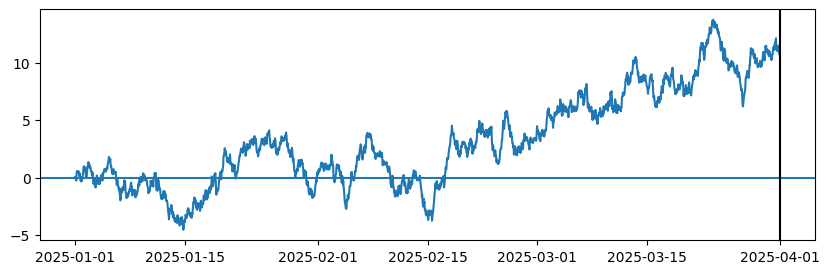

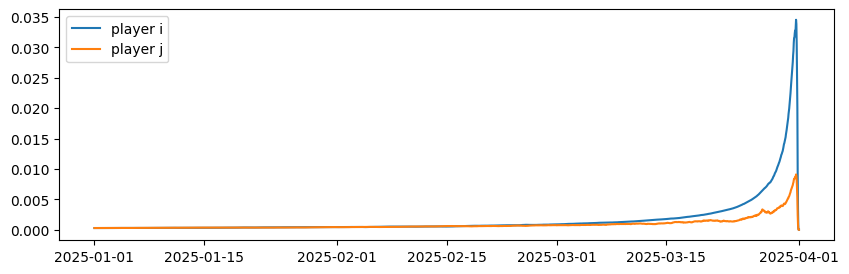

In [5]:
plt.figure(figsize=(10, 3))
plt.plot(contest_timeticks, dynamics_gap)
yrange = plt.ylim()
xrange = plt.xlim()
plt.hlines(y = 0, xmin=xrange[0], xmax=xrange[1])
plt.vlines(x = end_time, ymin=yrange[0], ymax=yrange[1], colors='black')  # type: ignore
plt.xlim(xrange)
plt.ylim(yrange)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(contest_timeticks, dynamic_i_effort, label='player i')
plt.plot(contest_timeticks, dynamic_j_effort, label='player j')
plt.legend()
plt.show()

### 3. Simulate Submission Data

In [6]:
effort_intensity_ratio = 5
seed_poisson = 1234
seed_uniform = 5678

[datetime.datetime(2025, 1, 25, 1, 10, 36, 805305),
 datetime.datetime(2025, 2, 5, 23, 43, 32, 521888),
 datetime.datetime(2025, 2, 22, 7, 25, 43, 848933),
 datetime.datetime(2025, 2, 22, 17, 40, 33, 259909),
 datetime.datetime(2025, 3, 6, 11, 2, 42, 814945),
 datetime.datetime(2025, 3, 23, 11, 54, 21, 469577),
 datetime.datetime(2025, 3, 26, 1, 51, 19, 308643),
 datetime.datetime(2025, 3, 26, 4, 2, 1, 470445),
 datetime.datetime(2025, 3, 26, 14, 13, 1, 680279),
 datetime.datetime(2025, 3, 27, 6, 56, 30, 440251),
 datetime.datetime(2025, 3, 27, 19, 35, 40, 482551),
 datetime.datetime(2025, 3, 28, 5, 17, 42, 362874),
 datetime.datetime(2025, 3, 28, 7, 57, 3, 807037),
 datetime.datetime(2025, 3, 28, 14, 43, 38, 686089),
 datetime.datetime(2025, 3, 31, 4, 2, 11, 284844)]


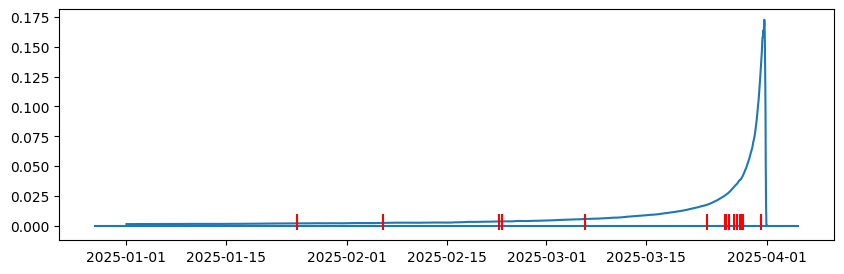

In [7]:
## Player i
##
# Interpolate effort as an intensity function
submission_intensity_i = nhpp.intensity_interp_d( \
		contest_timeticks, dynamic_i_effort, ratio=effort_intensity_ratio)

# Simulate submission data
submit_events_i = nhpp.simulate_inhomogeneous_poisson_process( \
		start_time, end_time, submission_intensity_i, 0.06,
		seed_poisson=seed_poisson, seed_uniform=seed_uniform)
pprint(submit_events_i)

# Visualization
fig, ax = nhpp.plot_intensity( \
		submission_intensity_i, (start_time, end_time), timedelta(hours=1))
ax = nhpp.plot_poisson_events(ax, submit_events_i)

[datetime.datetime(2025, 1, 25, 1, 10, 36, 805305),
 datetime.datetime(2025, 2, 5, 23, 43, 32, 521888),
 datetime.datetime(2025, 2, 22, 7, 25, 43, 848933),
 datetime.datetime(2025, 2, 22, 17, 40, 33, 259909),
 datetime.datetime(2025, 3, 6, 11, 2, 42, 814945),
 datetime.datetime(2025, 3, 26, 14, 13, 1, 680279),
 datetime.datetime(2025, 3, 27, 6, 56, 30, 440251),
 datetime.datetime(2025, 3, 27, 19, 35, 40, 482551),
 datetime.datetime(2025, 3, 28, 14, 43, 38, 686089),
 datetime.datetime(2025, 3, 31, 4, 2, 11, 284844)]


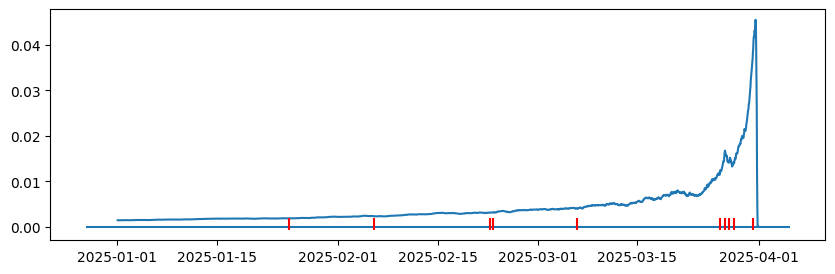

In [8]:
## Player j
##
# Interpolate effort as an intensity function
submission_intensity_j = nhpp.intensity_interp_d( \
		contest_timeticks, dynamic_j_effort, ratio=effort_intensity_ratio)

# Simulate submission data
submit_events_j = nhpp.simulate_inhomogeneous_poisson_process( \
		start_time, end_time, submission_intensity_j, 0.06,
		seed_poisson=seed_poisson, seed_uniform=seed_uniform)
pprint(submit_events_j)

# Visualization
fig, ax = nhpp.plot_intensity( \
		submission_intensity_j, (start_time, end_time), timedelta(hours=1))
ax = nhpp.plot_poisson_events(ax, submit_events_j, vline_width=0.002)

### 4. Bayesian Estimation